<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Load-data" data-toc-modified-id="Load-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load data</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Load-network" data-toc-modified-id="Load-network-1.0.1"><span class="toc-item-num">1.0.1&nbsp;&nbsp;</span>Load network</a></span></li><li><span><a href="#Load-cases" data-toc-modified-id="Load-cases-1.0.2"><span class="toc-item-num">1.0.2&nbsp;&nbsp;</span>Load cases</a></span></li></ul></li></ul></li></ul></div>

# Learning Generation - Part 1

We first start without line capacity constraints and fit a single training example.

In [6]:
using Pkg; Pkg.activate()

using DataFrames, CSV
using Distributions, Random  
using Plots
using LinearAlgebra

using Revise
using CarbonNetworks

# Load data

### Load network

In [2]:
DATAPATH = "/Users/degleris/Data/carbon_networks/"
A, gmax, pmax, f, G, nodes = parse_network_data(DATAPATH; num_generators=1)
n = length(gmax)
m = length(pmax)

# Remove infinite capacities
# pmax[pmax .== Inf] .= 3*maximum(gmax)
pmax .= 2*maximum(gmax)

normalization = mean(gmax)
gmax /= normalization
pmax /= normalization

@show n, m;

agg_nodes, B = create_generation_map(nodes);

(n, m) = (380, 471)


### Load cases

In [3]:
file_names = joinpath.(joinpath(DATAPATH, "TRAIN"), readdir(joinpath(DATAPATH, "TRAIN")))

cases = []
for file in file_names   
    d, g, case = load_case(file, agg_nodes, B, nodes)
    d = d/normalization
    g = g/normalization
    push!(cases, (d=d, g=g, case=case))
end

train_size = 1
test_size = 1

train_cases = cases[1:train_size]
test_cases = cases[100:100];

# Initialize

In [7]:
# Seeds that seem to work: 706
seed = 706  # rand(1:1_000)
Random.seed!(seed)

# Initialize estimated costs
f̂q = max.(1.0, 3 .+ randn(n)) 
f̂l = max.(1.0, 3 .+ randn(n))
# rand(Exponential(5), n) .+ 2 
# 2 .+ rand(n)

@show norm(f̂q)

train_loss_hist = []
test_loss_hist = []
grad_hist = []

norm(f̂q) = 61.45482146043804


Any[]

# Fit

In [37]:
# Algorithm parameters
step_size = 50.0
max_iter = 200
batch_size = 1
test_batch_size = 1

1

In [47]:
@time for iter in 1:max_iter
    if mod(iter, 50) == 0
        print("$(iter)-")
    end
    # Evaluate loss and gradient
    sample = rand(1:length(train_cases), batch_size)
    L, dfq, dfl = stochastic_loss_and_grad(f̂q, f̂l, B, train_cases, pmax, gmax, A, sample)
    
    push!(train_loss_hist, L)
    push!(grad_hist, dfq)
    
    # Compute test loss
    # sample = rand(1:length(test_cases), test_batch_size)
    # L_test, _ = stochastic_loss_and_grad(f̂, B, test_cases, pmax, gmax, A, sample)
    # push!(test_loss_hist, L_test)
    
    # Take projected gradient step
    # df += (1/n) * f̂
    ηq = 0.01 * min(norm(dfq), step_size)
    f̂q = max.(f̂q - ηq*(dfq/norm(dfq)), 0)
    
    ηl = 0.01 * min(norm(dfl), step_size)
    f̂l = max.(f̂l - ηl*(dfq/norm(dfl)), 0)
end

@show minimum(train_loss_hist)
println("Completed $(max_iter) iterations.")

50-100-150-200-  7.451337 seconds (6.97 M allocations: 3.764 GiB, 3.72% gc time)
minimum(train_loss_hist) = 0.2045653081784492
Completed 200 iterations.


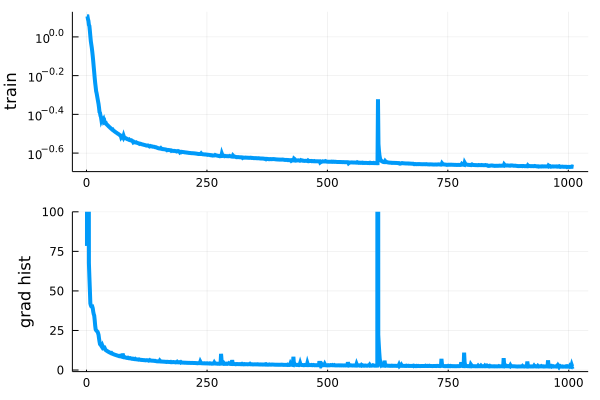

In [39]:
theme(:default, lw=4, label=nothing)

plot(
    plot(train_loss_hist, ylabel="train", yscale=:log10),
    plot(norm.(grad_hist),ylabel="grad hist", ylim=(-1, 100)),
    layout=(2, 1)
)

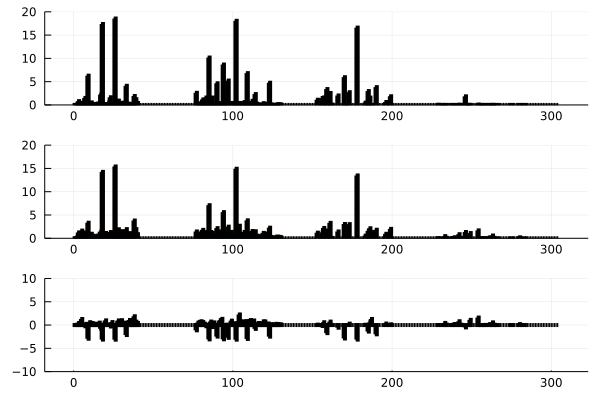

In [43]:
ĝ, opf, params = CarbonNetworks.solvePMP(f̂q, f̂l, train_cases[1], pmax, gmax, A)

plot(
    bar(train_cases[1].g, ylim=(0, 20)),
    bar(B*ĝ, ylim=(0, 20)),
    bar(B*ĝ - train_cases[1].g, ylim=(-10, 10)),
    layout=(3, 1)
)

┌ Info: Saved animation to 
│   fn = /Users/degleris/Documents/Research/CarbonNetworks/notebooks/tmp.gif
└ @ Plots /Users/degleris/.julia/packages/Plots/vVVub/src/animation.jl:104


Plots.AnimatedGif("/Users/degleris/Documents/Research/CarbonNetworks/notebooks/tmp.gif")
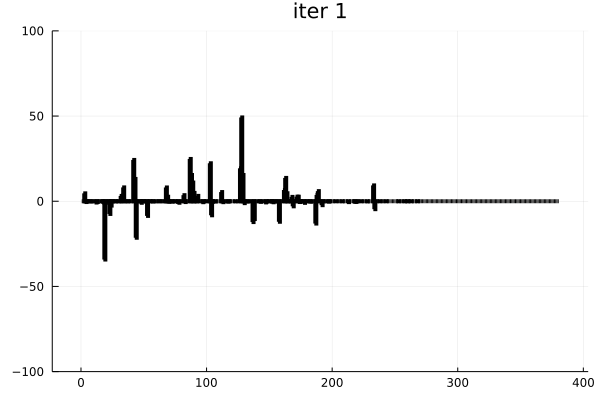

In [230]:
@gif for iter in 1:10_000
    iter = ceil(Int, iter / 5)
    bar(grad_hist[iter], ylim=(-100, 100), title="iter $iter")
end